In [199]:
import numpy as np
import pandas as pd 
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import fnmatch
import re

from ArapucaRoutineMainFunctions import *

In [200]:
#base_path = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/mod304'
base_path = '/Users/bordoni/protoDUNE/XeDoping/testfiles'
file_path = os.path.join(base_path,'*.dat')

file_name_list =  glob.glob(file_path) 

file_name_list


['/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch6.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch7.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11099_evt4005_mod603_ch9.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch5.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch11.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch10.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch4.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11099_evt4005_mod603_ch8.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch0.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch1.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch3.dat',
 '/Users/bordoni/protoDUNE/XeDoping/testfiles/run11107_evt12002_mod603_ch2.dat',
 '/Users/bordoni/protoDUNE/X

In [295]:
file_name_dict = [parse_file_name(base_path, f) for f in file_name_list]

In [296]:
def loc_file_for_run(dictt, run=123445):
    return [ f['file_name'] for f in dictt if f['run_number'] == str(run)]


def loc_file_for_run_and_channel(dictt, run=1234567, ch=4):
    return [ f['file_name'] for f in dictt if f['run_number'] == str(run) and f['channel'] == str(ch)]



def loc_create_dataset_list(file_name_dict, run=1234567):
    
    df_list = []
    for c in range(0,12):
        tmp_filelist = loc_file_for_run_and_channel(file_name_dict, run, c)
        #tmp_filelist = loc_file_for_run(file_name_dict, run=1234567)
        print('Run ', run , '  has for channel ', c, '  ', len(tmp_filelist), 'files'  )
        #print(tmp_filelist)

        df_tmp = readfile_list(tmp_filelist)
        #print(type(df_tmp))
        
        df_list.append(df_tmp)

    print('loaded ', len(df_list), 'channels for this run' )    
    return df_list

In [297]:
runlist = [ r['run_number'] for r in file_name_dict ]
runlist = list(set(runlist))

print('Full list of runs to process : \n', runlist )

Full list of runs to process : 
 ['11099', '11107', '11102']


In [298]:
for r in runlist:
    print('loading files for run ', r)
    df_list = loc_create_dataset_list(file_name_dict, run=r)

    print('loaed channels for this run : ' , len(df_list) )


loading files for run  11099
Run  11099   has  12 files
loaed channels for this run :  1
loading files for run  11107
Run  11107   has  12 files


KeyboardInterrupt: 

In [294]:
runlist = [ r['run_number'] for r in file_name_dict ]
runlist = list(set(runlist))

for r in runlist:
    print('loading files for run ', r)
    #tmp_filelist = loc_file_for_run(file_name_dict, run=r)
    tmp_filelist = loc_create_dataset_list(file_name_dict, run=r)
    #print(tmp_filelist)

loading files for run  11099
Run  11099   has  12 files
loading files for run  11107
Run  11107   has  12 files
loading files for run  11102
Run  11102   has  12 files


In [284]:
test_list = loc_create_dataset_list(file_name_dict)

['11099', '11107', '11102']
loading files for run  11099
loading files for run  11107
loading files for run  11102


In [202]:
df_list = create_dataset_list(file_name_dict)
df_list[0].shape

loading files for channel  0
loading files for channel  1
loading files for channel  2
loading files for channel  3
loading files for channel  4
loading files for channel  5
loading files for channel  6
loading files for channel  7
loading files for channel  8
loading files for channel  9
loading files for channel  10
loading files for channel  11


(2998, 2024)

In [203]:
df_list_proc = doPreProcessing(df_list)

preparing dataframe for channel :  1
preparing dataframe for channel :  2
preparing dataframe for channel :  3
preparing dataframe for channel :  4
preparing dataframe for channel :  5
preparing dataframe for channel :  6
preparing dataframe for channel :  7
preparing dataframe for channel :  8
preparing dataframe for channel :  9
preparing dataframe for channel :  10
preparing dataframe for channel :  11
preparing dataframe for channel :  12
done!
preprocessing done!


In [204]:
df_list_proc[0].head()

,Ch,Run number,Evt number,0,1,2,3,4,5,6,...,2021,2022,2023,Saturated,Pedestal,hasSignal,n pe,pe height,pe width,pe area
0,0,11107,8002,11107.0,1.0,8002.0,603.0,48.0,0.0,264.0,...,-1.046667,-1.113333,-1.013333,False,1579.18,False,0.0,0.000000,0.000000,0.000000
1,0,11107,8004,11107.0,1.0,8004.0,603.0,48.0,0.0,264.0,...,-13.703333,-13.603333,-13.436667,False,1590.27,True,0.0,0.000000,0.000000,0.000000
2,0,11107,8006,11107.0,1.0,8006.0,603.0,48.0,0.0,264.0,...,-3.710000,-3.776667,-3.743333,False,1578.31,True,0.0,0.000000,0.000000,0.000000
3,0,11107,8008,11107.0,1.0,8008.0,603.0,48.0,0.0,264.0,...,0.006667,0.173333,0.106667,False,1579.06,False,1.0,6.440000,97.883333,419.686667
4,0,11107,8010,11107.0,1.0,8010.0,603.0,48.0,0.0,264.0,...,-2.023333,-2.290000,-2.290000,False,1578.59,True,1.0,8.143333,61.244048,376.876667


In [205]:
def do_average_wf(dflist):
    df_av_wf = []
    
    for df in dflist:

        df_tmp = (df.loc[ (df['Saturated'] == False ) & (df['hasSignal'] == True )].groupby(['Run number', 'Ch'])[wf].mean() )
        
        df_av_wf.append(df_tmp)
       
   
    return pd.concat(df_av_wf).reset_index()

In [206]:
df_av_wf = do_average_wf(df_list_proc)
df_av_wf.head()

,Run number,Ch,700,701,702,703,704,705,706,707,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,11099,0,0.720714,0.712656,0.707070,0.708077,0.705788,0.712289,0.726117,0.718608,...,0.833535,0.837289,0.826484,0.815311,0.805421,0.780604,0.755055,0.733352,0.738388,0.714945
1,11102,0,0.580272,0.604137,0.605953,0.607769,0.627873,0.630856,0.638249,0.653424,...,0.118664,0.118275,0.106213,0.102711,0.111012,0.123852,0.138379,0.151089,0.167302,0.164189
2,11107,0,0.559635,0.569529,0.568280,0.572411,0.553967,0.536964,0.538117,0.535043,...,0.499885,0.494697,0.503631,0.517080,0.516503,0.521114,0.518617,0.528223,0.517656,0.513237
3,11099,1,1.100486,1.109258,1.103118,1.101603,1.103437,1.099211,1.107663,1.117073,...,0.891874,0.890598,0.878876,0.866276,0.848094,0.825925,0.813565,0.795861,0.783501,0.782943
4,11102,1,0.582535,0.565289,0.566215,0.555914,0.544225,0.530220,0.529294,0.522581,...,0.254178,0.246771,0.235891,0.214711,0.194456,0.189479,0.183808,0.162396,0.163437,0.153831


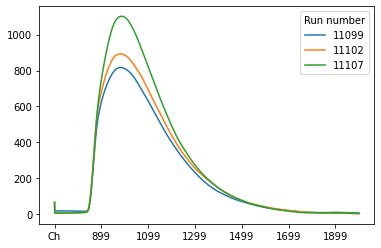

In [207]:
df_av_wf.groupby(['Run number']).sum().T.plot()

In [208]:
def do_average_singlepe(dflist):
    df_av_spe = []
    
    for df in dflist:

        df_tmp = df.loc[ (df['n pe'] >0) ].groupby(['Run number', 'Ch'])['pe area'].mean() 
        
        df_av_spe.append(df_tmp)
       
   
    return pd.concat(df_av_spe)

In [245]:
df_average_spe = do_average_singlepe(df_list_proc).to_frame()
df_average_spe.reset_index(inplace = True)
tmp = df_average_spe.pivot(index='Run number', columns='Ch', values='pe area')
tmp
df_calib = tmp.div(tmp[0], axis = 0)
df_calib

Ch,0,1,2,3,4,5,6,7,8,9,10,11
Run number,,,,,,,,,,,,
11099,1.0,1.075630,1.018810,0.978745,1.056059,0.932960,0.941649,1.022839,0.917949,1.032745,0.994247,0.986184
11102,1.0,1.014482,1.003572,0.936137,1.004916,0.889312,0.867152,0.982666,0.945255,1.031743,0.979050,0.999420
11107,1.0,0.993875,0.957320,0.968172,1.024213,0.909203,0.924718,0.982101,0.931540,0.996731,1.012577,0.973854


In [219]:
df_calib_2 = df_calib.T.stack(level=0).to_frame(name='f_cal').reset_index()
df_calib_2.head()

,Ch,Run number,f_cal
0,0,11099,1.000000
1,0,11102,1.000000
2,0,11107,1.000000
3,1,11099,1.075630
4,1,11102,1.014482


In [221]:
df_av_wf.head()

,Run number,Ch,700,701,702,703,704,705,706,707,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,11099,0,0.720714,0.712656,0.707070,0.708077,0.705788,0.712289,0.726117,0.718608,...,0.833535,0.837289,0.826484,0.815311,0.805421,0.780604,0.755055,0.733352,0.738388,0.714945
1,11102,0,0.580272,0.604137,0.605953,0.607769,0.627873,0.630856,0.638249,0.653424,...,0.118664,0.118275,0.106213,0.102711,0.111012,0.123852,0.138379,0.151089,0.167302,0.164189
2,11107,0,0.559635,0.569529,0.568280,0.572411,0.553967,0.536964,0.538117,0.535043,...,0.499885,0.494697,0.503631,0.517080,0.516503,0.521114,0.518617,0.528223,0.517656,0.513237
3,11099,1,1.100486,1.109258,1.103118,1.101603,1.103437,1.099211,1.107663,1.117073,...,0.891874,0.890598,0.878876,0.866276,0.848094,0.825925,0.813565,0.795861,0.783501,0.782943
4,11102,1,0.582535,0.565289,0.566215,0.555914,0.544225,0.530220,0.529294,0.522581,...,0.254178,0.246771,0.235891,0.214711,0.194456,0.189479,0.183808,0.162396,0.163437,0.153831


In [222]:
df_average_spe.head()

,Run number,Ch,pe area
0,11099,0,429.776489
1,11102,0,443.448819
2,11107,0,447.963273
3,11099,1,462.280681
4,11102,1,449.870714


In [224]:
df_av_wf_cp = pd.merge(df_av_wf_cp, df_calib_2, left_on=['Run number', 'Ch'], right_on=['Run number', 'Ch'])
df_av_wf_cp.head()

,Run number,Ch,700,701,702,703,704,705,706,707,...,1992,1993,1994,1995,1996,1997,1998,1999,pe area,f_cal
0,11099,0,0.720714,0.712656,0.707070,0.708077,0.705788,0.712289,0.726117,0.718608,...,0.826484,0.815311,0.805421,0.780604,0.755055,0.733352,0.738388,0.714945,429.776489,1.000000
1,11102,0,0.580272,0.604137,0.605953,0.607769,0.627873,0.630856,0.638249,0.653424,...,0.106213,0.102711,0.111012,0.123852,0.138379,0.151089,0.167302,0.164189,443.448819,1.000000
2,11107,0,0.559635,0.569529,0.568280,0.572411,0.553967,0.536964,0.538117,0.535043,...,0.503631,0.517080,0.516503,0.521114,0.518617,0.528223,0.517656,0.513237,447.963273,1.000000
3,11099,1,1.100486,1.109258,1.103118,1.101603,1.103437,1.099211,1.107663,1.117073,...,0.878876,0.866276,0.848094,0.825925,0.813565,0.795861,0.783501,0.782943,462.280681,1.075630
4,11102,1,0.582535,0.565289,0.566215,0.555914,0.544225,0.530220,0.529294,0.522581,...,0.235891,0.214711,0.194456,0.189479,0.183808,0.162396,0.163437,0.153831,449.870714,1.014482


In [223]:
df_av_wf_cp = pd.merge(df_av_wf, df_average_spe, left_on=['Run number', 'Ch'], right_on=['Run number', 'Ch'])
df_av_wf_cp.head()

,Run number,Ch,700,701,702,703,704,705,706,707,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,pe area
0,11099,0,0.720714,0.712656,0.707070,0.708077,0.705788,0.712289,0.726117,0.718608,...,0.837289,0.826484,0.815311,0.805421,0.780604,0.755055,0.733352,0.738388,0.714945,429.776489
1,11102,0,0.580272,0.604137,0.605953,0.607769,0.627873,0.630856,0.638249,0.653424,...,0.118275,0.106213,0.102711,0.111012,0.123852,0.138379,0.151089,0.167302,0.164189,443.448819
2,11107,0,0.559635,0.569529,0.568280,0.572411,0.553967,0.536964,0.538117,0.535043,...,0.494697,0.503631,0.517080,0.516503,0.521114,0.518617,0.528223,0.517656,0.513237,447.963273
3,11099,1,1.100486,1.109258,1.103118,1.101603,1.103437,1.099211,1.107663,1.117073,...,0.890598,0.878876,0.866276,0.848094,0.825925,0.813565,0.795861,0.783501,0.782943,462.280681
4,11102,1,0.582535,0.565289,0.566215,0.555914,0.544225,0.530220,0.529294,0.522581,...,0.246771,0.235891,0.214711,0.194456,0.189479,0.183808,0.162396,0.163437,0.153831,449.870714


In [225]:
def calibrate_av_wf(df):
    df.copy()
    df[wf] = df[wf].divide(df['f_cal'], axis=0)
    return df

In [226]:
df_av_wf_cal = calibrate_av_wf(df_av_wf_cp)
df_av_wf_cal.head()

,Run number,Ch,700,701,702,703,704,705,706,707,...,1992,1993,1994,1995,1996,1997,1998,1999,pe area,f_cal
0,11099,0,0.720714,0.712656,0.707070,0.708077,0.705788,0.712289,0.726117,0.718608,...,0.826484,0.815311,0.805421,0.780604,0.755055,0.733352,0.738388,0.714945,429.776489,1.000000
1,11102,0,0.580272,0.604137,0.605953,0.607769,0.627873,0.630856,0.638249,0.653424,...,0.106213,0.102711,0.111012,0.123852,0.138379,0.151089,0.167302,0.164189,443.448819,1.000000
2,11107,0,0.559635,0.569529,0.568280,0.572411,0.553967,0.536964,0.538117,0.535043,...,0.503631,0.517080,0.516503,0.521114,0.518617,0.528223,0.517656,0.513237,447.963273,1.000000
3,11099,1,1.023108,1.031263,1.025555,1.024146,1.025851,1.021922,1.029781,1.038529,...,0.817080,0.805366,0.788462,0.767852,0.756361,0.739902,0.728411,0.727892,462.280681,1.075630
4,11102,1,0.574219,0.557220,0.558133,0.547979,0.536456,0.522651,0.521738,0.515121,...,0.232524,0.211646,0.191680,0.186774,0.181184,0.160078,0.161104,0.151635,449.870714,1.014482


In [247]:
rundir = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/mod304/rundir'
csvdir = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/mod304/csvdir'
df_allch = doEventSelection(df_list, rundir, csvdir)

KeyError: 'evt number'

In [253]:
df_wf_calibrated[3:1300].max(axis=0)

Run number
11099     818.707843
11102     916.767016
11107    1132.261460
dtype: float64

Run number
11099     817.050888
11102     892.578466
11107    1102.093992
dtype: float64


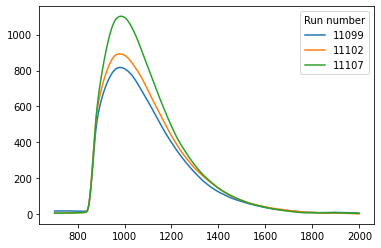

In [255]:
df_wf_raw = df_av_wf.groupby(['Run number']).sum().T
print(df_wf_raw[3:1300].max(axis=0) )
df_wf_raw[3:1300].plot()

In [261]:
df_integral_calib = df_av_wf_cal.groupby(['Run number']).sum()
df_integral_calib = tmp.sum(axis=1).to_frame().reset_index()

#df_integral_calib = df_wf_calibrated.groupby(['Run number']).sum()
df_integral_calib

,Run number,0
0,11099,5139.188384
1,11102,5167.821914
2,11107,5229.659013


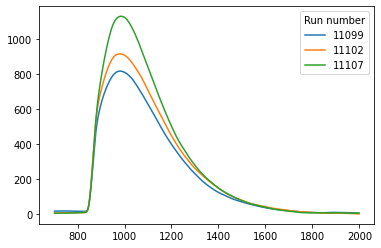

In [251]:
#df_av_wf_cal.groupby(['Run number']).sum().T.plot()
df_wf_calibrated = df_av_wf_cal.groupby(['Run number']).sum().T
df_wf_calibrated[3:1300].plot()